In [42]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 2.5 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/home/giuli/Documentos/GitHub/Leaf-Detection/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os 

In [3]:
sns.set_style ("darkgrid")
mean_plot = 3
num = 40

In [83]:
frames : list = []

csv : list = ["leaf_masking/GRUPO_6/csv/GRUPO_6.csv",
              "leaf_masking/GRUPO_7/csv/GRUPO_7.csv"]

for csv_ in csv:
    temp_df : pd.DataFrame =  pd.read_csv(os.path.join(os.getcwd(), csv_), index_col=False).drop('Unnamed: 0', axis=1)
    frames.append(temp_df)

df = pd.concat(frames)

VALOR MINIMO:-0.421296479350948
VALOR MAXIMO:1.0


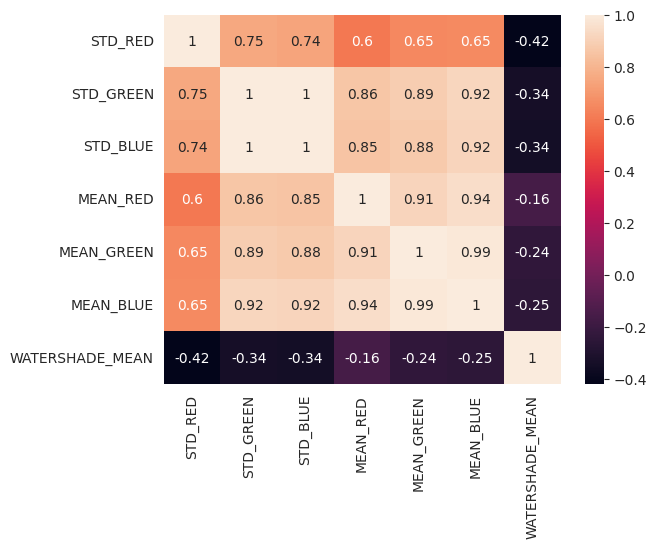

In [85]:
corr : pd.DataFrame = df.drop('GROUP', axis = 1).corr()
print(f'VALOR MINIMO:{corr.values.min()}')
print(f'VALOR MAXIMO:{corr.values.max()}')
sns.heatmap(corr, annot=True);

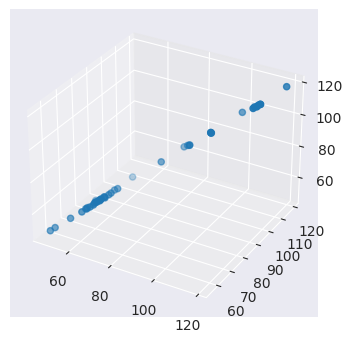

In [19]:
plt.figure(figsize = (5, 4))
plot_axes = plt.axes(projection = '3d')
plot_axes.scatter3D(df['MEAN_BLUE'], df['MEAN_GREEN'], df['MEAN_BLUE'])
plt.show()

In [28]:
df.to_csv('leaf_data.csv', index=False)

## Implementamos algoritmo on sklearn

In [86]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics

datos : pd.DataFrame = df.drop(['GROUP'], axis=1)

datos_escalados = preprocessing.scale(datos)

In [87]:
datos_escalados.mean(axis=0)

array([ 7.54951657e-16, -1.67767035e-16, -1.13489465e-16, -5.72381648e-16,
       -5.82250297e-16, -3.92278802e-16, -3.45402719e-17])

In [88]:
kmeans = KMeans(n_clusters=2,  
                random_state=1,
                n_init=2).fit(datos);
kmeans.labels_ # Nos indica a que cluster pertenece cada observación
print(f'J-Squared: {kmeans.inertia_}')

J-Squared: 6921.332571847243


In [74]:
def scatter(c0 : str, c1 : str) -> None:
    plt.figure(figsize=(14, 5));
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=datos,
                x=c0,
                y=c1,
                hue = kmeans.labels_,
                legend=False,
                s = 200,
                palette = sns.color_palette("husl", 2),
                alpha=0.7).tick_params(left=False);
    plt.title("Predicciones")
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=datos,
                x=c0,
                y=c1,
                hue = df['GROUP'],
                legend=False,
                s = 200,
                palette = sns.color_palette("husl", 2),
                alpha=0.7).tick_params(left=False);
    plt.title("Labels reales")

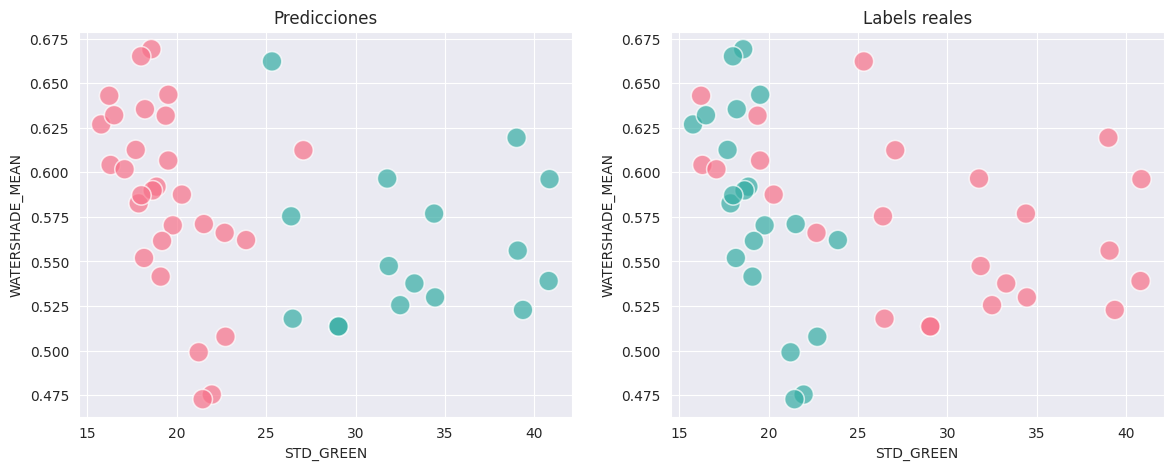

In [90]:
scatter('STD_GREEN', 
        'WATERSHADE_MEAN')

## Implementamos algoritmo Kmeans con tensorflow

$\text{arg } \text{min } \text{d(c, x) }  c\in S$

In [77]:
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [94]:
import pathlib
data_dir = pathlib.Path('./leaf_keras_dataset/')

In [95]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

45


In [98]:
grupo_6 = list(data_dir.glob('GRUPO_6/*'))

In [104]:
batch_size : int = 32
img_height : int = 250
img_width : int = 180

In [105]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 45 files belonging to 2 classes.
Using 36 files for training.


In [106]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 45 files belonging to 2 classes.
Using 9 files for validation.


In [107]:
class_names = train_ds.class_names
print(class_names)

['GRUPO_6', 'GRUPO_7']


2023-05-19 11:57:21.329413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [36]
	 [[{{node Placeholder/_4}}]]
2023-05-19 11:57:21.331599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [36]
	 [[{{node Placeholder/_0}}]]
2023-05-19 11:57:22.303790: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17280000 exceeds 10% of free system memory.


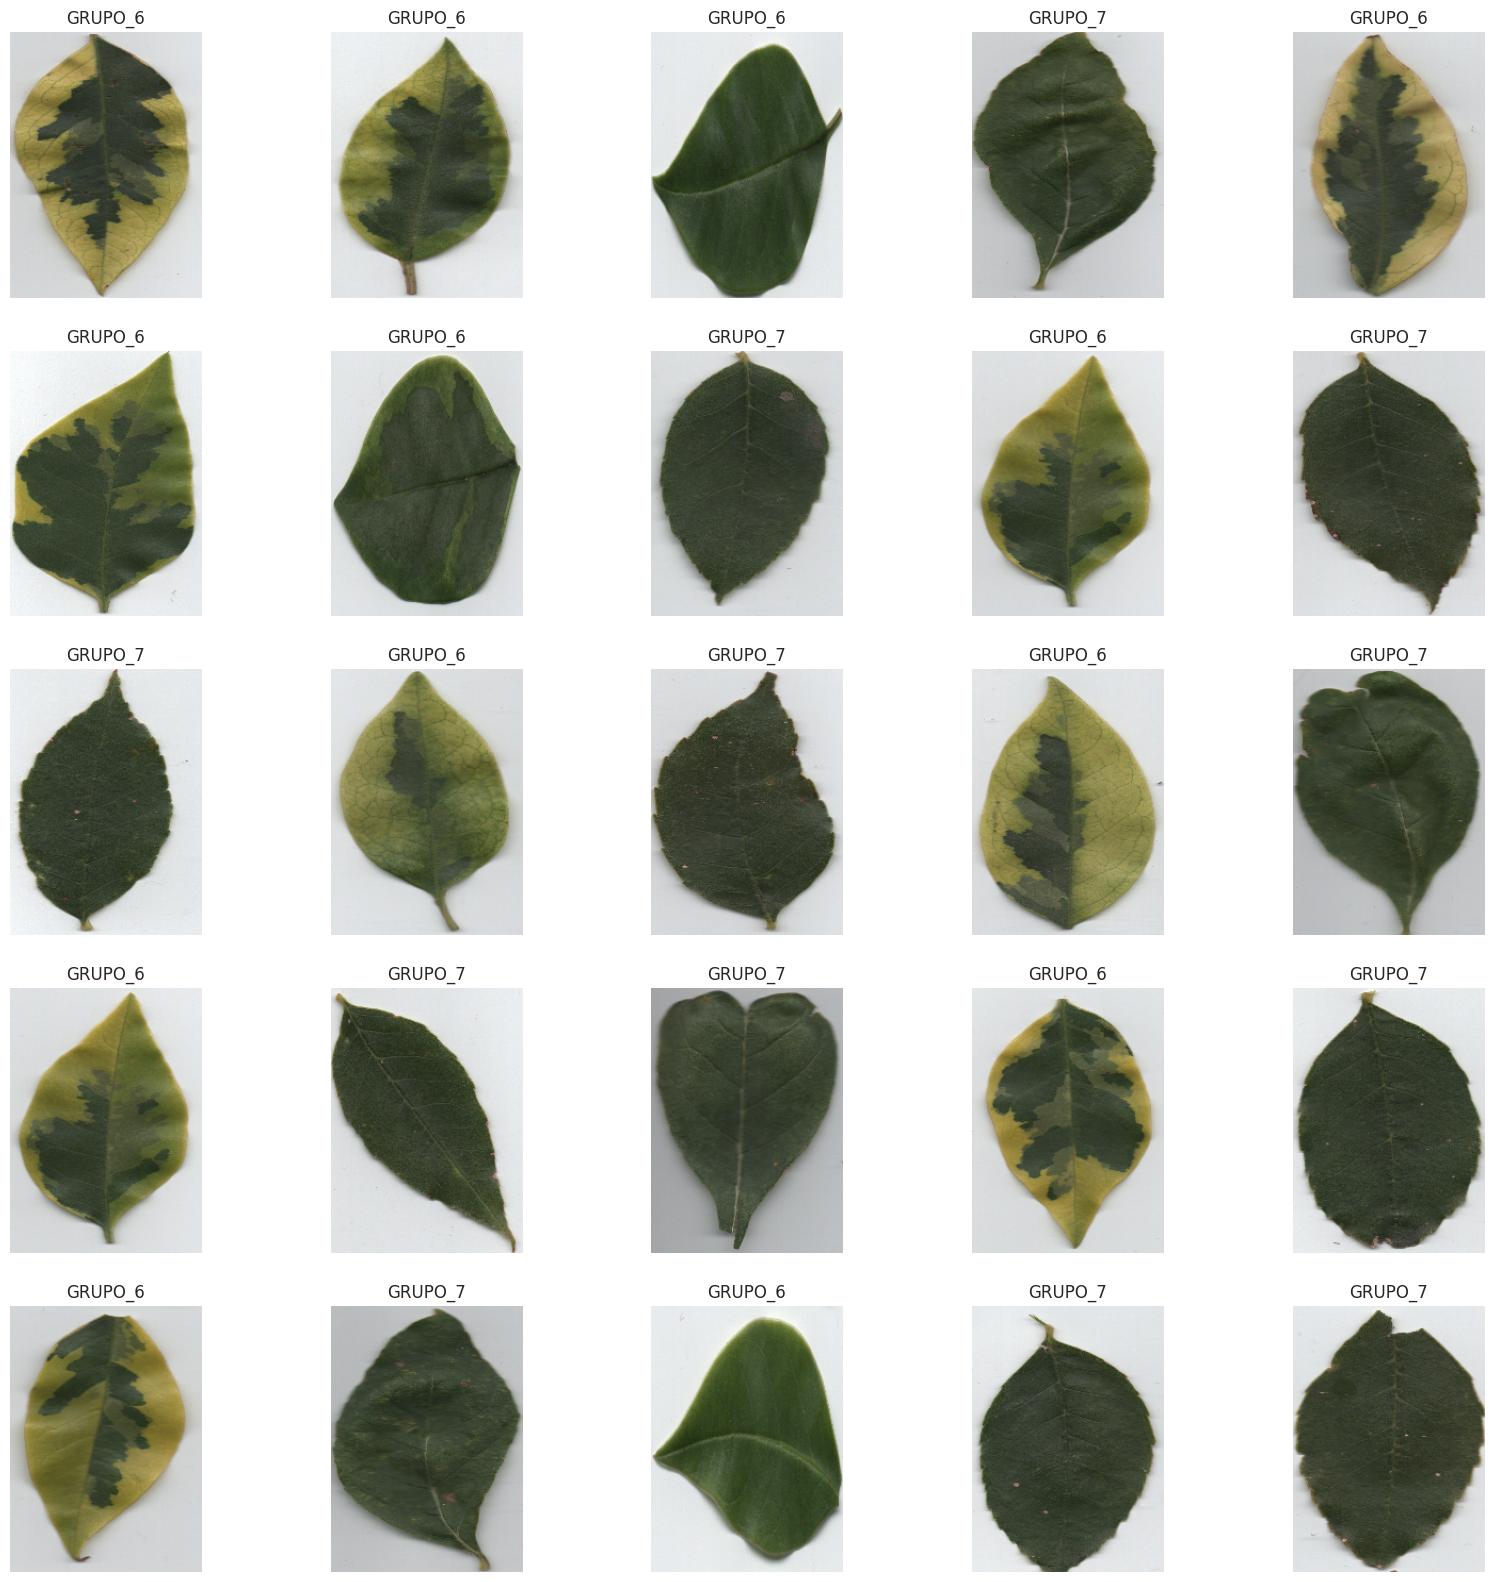

In [111]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [112]:
normalization_layer = layers.Rescaling(1./255)

In [113]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Capa de reescalado
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

2023-05-19 12:01:51.055572: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22347776 exceeds 10% of free system memory.


In [114]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Perdida en base a la entropía entre las labels reales y las predicciones
              metrics=['accuracy'])

In [115]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 250, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 90, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 90, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 45, 64)        1

In [116]:
# Entrenamiento del modelo
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-05-19 12:04:04.227025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [36]
	 [[{{node Placeholder/_0}}]]
2023-05-19 12:04:04.228687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [36]
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - ETA: 0s - loss: 1.8359 - accuracy: 0.4444

2023-05-19 12:04:13.191412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [9]
	 [[{{node Placeholder/_0}}]]
2023-05-19 12:04:13.193228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [9]
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 10s 2s/step - loss: 1.8359 - accuracy: 0.4444 - val_loss: 0.7828 - val_accuracy: 0.4444
Epoch 2/10
2/2 [==============================] - 7s 2s/step - loss: 0.5888 - accuracy: 0.6111 - val_loss: 0.8133 - val_accuracy: 0.4444
Epoch 3/10
2/2 [==============================] - 5s 1s/step - loss: 0.7144 - accuracy: 0.5000 - val_loss: 0.7193 - val_accuracy: 0.4444
Epoch 4/10
2/2 [==============================] - 6s 1s/step - loss: 0.6562 - accuracy: 0.5556 - val_loss: 0.7410 - val_accuracy: 0.4444
Epoch 5/10
2/2 [==============================] - 5s 1s/step - loss: 0.6468 - accuracy: 0.5556 - val_loss: 0.7113 - val_accuracy: 0.4444
Epoch 6/10
2/2 [==============================] - 4s 1s/step - loss: 0.6341 - accuracy: 0.6389 - val_loss: 0.7070 - val_accuracy: 0.4444
Epoch 7/10
2/2 [==============================] - 4s 1s/step - loss: 0.6106 - accuracy: 0.7500 - val_loss: 0.7584 - val_accuracy: 0.4444
Epoch 8/10
2/2 [==============================] - 4

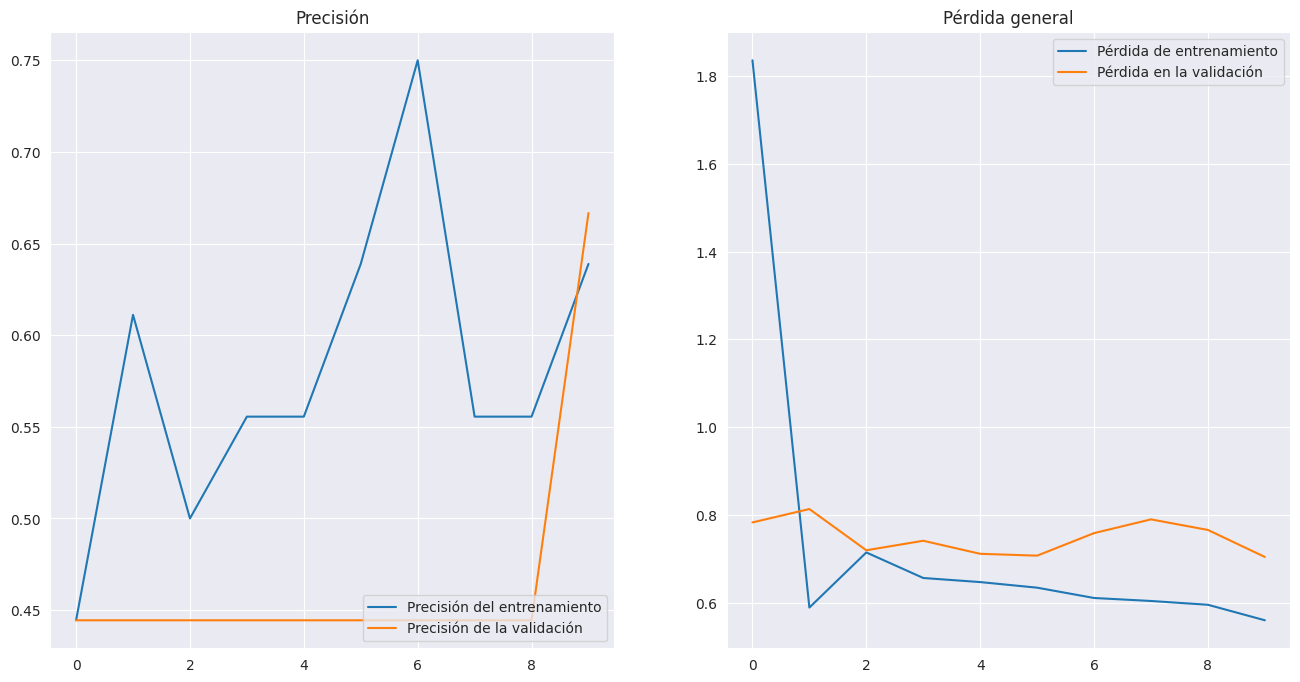

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión del entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de la validación')
plt.legend(loc='lower right')
plt.title('Precisión')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida en la validación')
plt.legend(loc='upper right')
plt.title('Pérdida general')
plt.show()

2023-05-19 12:07:36.415410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [36]
	 [[{{node Placeholder/_0}}]]
2023-05-19 12:07:36.416036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [36]
	 [[{{node Placeholder/_4}}]]


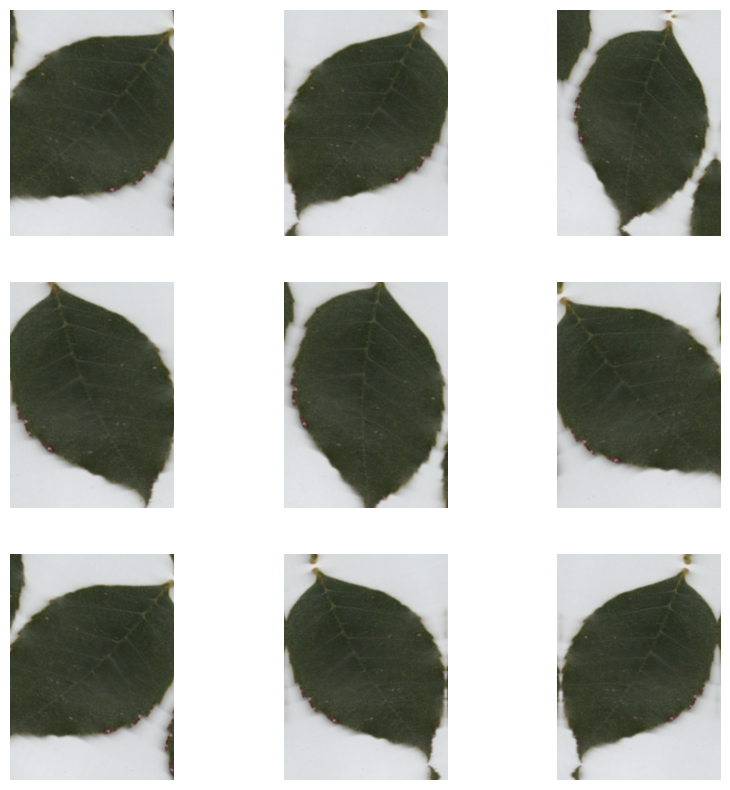

In [119]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [121]:
model.save('modelo')

INFO:tensorflow:Assets written to: modelo/assets


INFO:tensorflow:Assets written to: modelo/assets
